<a href="https://colab.research.google.com/github/roinemilko/trashbot/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 15.5 MB/s eta 0:00:00


In [ ]:
import kagglehub
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

Using Colab cache for faster access to the 'garbage-classification' dataset.


In [ ]:
print(f'path: {path}')

path: /kaggle/input/garbage-classification


Preprocessing:
- Random resize to introduce scale and translation invariance
- Random flip to reduce overfitting
- Colorjitter to make robust to color variations
- Random grayscale to make the model more reliant on shape, texture etc. than color. i.e. to reduce the likelyhood of classifying packaging by color
- Normalize for for resnet50

In [ ]:
import os
import PIL
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms, models

labels_dic = {'cardboard':0,
              'glass':1,
              'metal':2,
              'paper':3,
              'plastic':4,
              'trash':5}
transforms = {'train':  transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.05),
                        transforms.RandomGrayscale(0.1),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
              'test':   transforms.Compose([
                        transforms.Resize(224),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

class Image(Dataset):
  def __init__(self, path, size, transform = None):
    self.size = size
    self.path = os.path.join(path, 'Garbage classification')
    self.path = os.path.join(self.path, 'Garbage classification')
    self.transform = transform
    self.img_paths = []
    self.img_labels = []

    for dir in os.listdir(self.path):
        current = os.path.join(self.path, dir)
        for img in os.listdir(current):
          self.img_paths.append(os.path.join(current, img))
          self.img_labels.append(dir)

  def __getitem__(self, idx):
    image = self.img_paths[idx]
    key = self.img_labels[idx]

    image = PIL.Image.open(image).convert('RGB')

    if self.transform:
      image = transforms[self.transform](image)

    return image, key

  def __len__(self):
    return len(self.img_labels)

Create train, test and validation sets.

In [ ]:
images_train, images_test = Image(path, 250, 'train'), Image(path, 250, 'test')

val_size = len(images_test) // 2
test_size = len(images_test) - val_size

train_load = DataLoader(images_train, 16, True)

test_set, val_set = random_split(
    images_test,
    [val_size, test_size]
)

test_load = DataLoader(test_set, 16, False)
val_load = DataLoader(val_set, 16, False)

Visualization of example images and classes.

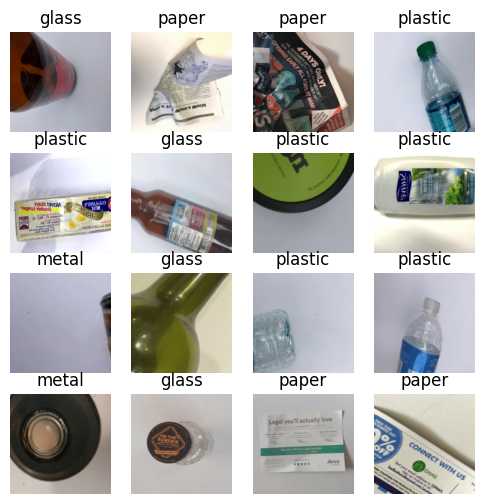

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(6,6))
rows, cols = (4,4)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(1, len(images_train), size=[1]).item()
  img, label = images_train[random_idx]
  img = img.permute(1,2,0).numpy()
  img = img * std + mean
  img = np.clip(img, 0 ,1)
  fig.add_subplot(rows, cols, i)
  plt.imshow(img)
  plt.title(label)
  plt.axis('off')

Train and test functions

In [ ]:
from tempfile import TemporaryDirectory
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(model, data, loss, optimizer, schedule, metric):
  model.train()
  running_loss = 0
  metric.reset()


  for input, label in data:
    input = input.to(device)
    label = torch.tensor([labels_dic[x] for x in label]).to(device)

    optimizer.zero_grad()
    output = model(input)
    current_loss = loss(output, label)
    current_loss.backward()

    running_loss += current_loss.item()
    metric.update(output, label)

    optimizer.step()

  epoch_loss = running_loss / len(data)
  epoch_metric = metric.compute().item()
  schedule.step()
  return epoch_loss, epoch_metric

@torch.no_grad()
def test(model, data, loss, metric):
  model.eval()
  running_loss = 0
  metric.reset()

  for input, label in data:

    input = input.to(device)
    label = torch.tensor([labels_dic[x] for x in label]).to(device)

    output = model(input)
    current_loss = loss(output, label)

    running_loss += current_loss.item()
    metric.update(output, label)

  epoch_loss = running_loss / len(data)
  epoch_metric = metric.compute().item()

  return epoch_loss, epoch_metric

@torch.no_grad()
def validate(model, data, loss, metric):
  model.eval()
  running_loss = 0
  metric.reset()
  preds = []
  labels = []

  for input, label in data:

    input = input.to(device)
    label = torch.tensor([labels_dic[x] for x in label]).to(device)

    output = model(input)
    preds.append(torch.max(output, 1)[1])
    labels.append(label)
    current_loss = loss(output, label)

    running_loss += current_loss.item()
    metric.update(output, label)

  epoch_loss = running_loss / len(data)
  epoch_metric = metric.compute().item()

  return {"loss": epoch_loss,
          "metric": epoch_metric,
          "predictions": preds,
          "labels": labels}

In [ ]:
print(device)

cuda


Initialize resnet 50 and run training with cross entropy losa and Adam.

In [ ]:
import tqdm
nofClasses = 6
model = models.resnet50(weights='IMAGENET1K_V2')
# for param in model.parameters():
#  param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, nofClasses)
model.to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def run():

  train_losscurve = []
  test_losscurve = []
  train_acc_curve = []
  test_acc_curve = []


  with TemporaryDirectory() as dir:
    best_params_dir = os.path.join(dir, 'best_params.pt')
    best_acc = 0.0
    print("Select n. of epochs:")
    epochs = int(input())

    for i in tqdm.tqdm(range(0, epochs)):
      train_loss, train_acc = train(model, train_load, loss_fn, optimizer, schedule, MulticlassAccuracy())
      test_loss, test_acc = test(model, test_load, loss_fn, MulticlassAccuracy())

      train_losscurve.append(train_loss)
      test_losscurve.append(test_loss)
      train_acc_curve.append(train_acc)
      test_acc_curve.append(test_acc)

      print(f"Epoch: {i+1}/{epochs}\n ----------\nTrain loss{train_loss} || Train acc: {train_acc}\nTest loss {test_loss} || Test acc {test_acc}\n\n")
      if (i == 1) or (test_acc > best_acc):
        best_acc = test_acc
        torch.save(model.state_dict(), best_params_dir)

      print(f"Best model saved with acc: {best_acc}.\n")

    model.load_state_dict(torch.load(best_params_dir, weights_only = True))
    print("Validating best model.. \n")
    val_result = validate(model, val_load, loss_fn, MulticlassAccuracy())
    print(f"Validation loss: {val_result["loss"]}, validation accuracy {val_result["metric"]}\n")

  return {'train loss': train_losscurve,
          'test loss': test_losscurve,
          'train acc': train_acc_curve,
          'test acc': test_acc_curve,
          'validation': val_result,
          'model': model}

In [ ]:
result = run()

Select n. of epochs:
10


 10%|█         | 1/10 [00:57<08:36, 57.39s/it]

Epoch: 1/10
 ----------
Train loss1.2989414798308023 || Train acc: 0.5227542519569397
Test loss 0.985602461839024 || Test acc 0.6413301825523376


Best model saved with acc: 0.6413301825523376.

Epoch: 2/10
 ----------
Train loss1.1162637521194507 || Train acc: 0.5979422330856323
Test loss 0.8349798702740971 || Test acc 0.7141726016998291




 20%|██        | 2/10 [01:55<07:43, 57.89s/it]

Best model saved with acc: 0.7141726016998291.



 30%|███       | 3/10 [02:52<06:42, 57.55s/it]

Epoch: 3/10
 ----------
Train loss1.013545958301689 || Train acc: 0.6248515844345093
Test loss 0.6739579171319551 || Test acc 0.7442597150802612


Best model saved with acc: 0.7442597150802612.



 40%|████      | 4/10 [03:50<05:45, 57.51s/it]

Epoch: 4/10
 ----------
Train loss0.8998698322456095 || Train acc: 0.6774832010269165
Test loss 0.6951554130904282 || Test acc 0.7347584962844849


Best model saved with acc: 0.7442597150802612.



 50%|█████     | 5/10 [04:48<04:48, 57.63s/it]

Epoch: 5/10
 ----------
Train loss0.8316665769000596 || Train acc: 0.6901464462280273
Test loss 0.5751285796301274 || Test acc 0.8020585775375366


Best model saved with acc: 0.8020585775375366.



 60%|██████    | 6/10 [05:45<03:49, 57.48s/it]

Epoch: 6/10
 ----------
Train loss0.6895298046779029 || Train acc: 0.7566283941268921
Test loss 0.3478163693901859 || Test acc 0.8859857320785522


Best model saved with acc: 0.8859857320785522.



 70%|███████   | 7/10 [06:42<02:52, 57.42s/it]

Epoch: 7/10
 ----------
Train loss0.598754417009746 || Train acc: 0.7906608581542969
Test loss 0.29171511078182655 || Test acc 0.9010292887687683


Best model saved with acc: 0.9010292887687683.



 80%|████████  | 8/10 [07:40<01:54, 57.46s/it]

Epoch: 8/10
 ----------
Train loss0.5301507775542103 || Train acc: 0.8187574148178101
Test loss 0.2697843866823595 || Test acc 0.9144893288612366


Best model saved with acc: 0.9144893288612366.



 90%|█████████ | 9/10 [08:37<00:57, 57.42s/it]

Epoch: 9/10
 ----------
Train loss0.48639912219553055 || Train acc: 0.8231104016304016
Test loss 0.26199041839830484 || Test acc 0.9152810573577881


Best model saved with acc: 0.9152810573577881.



100%|██████████| 10/10 [09:33<00:00, 57.39s/it]

Epoch: 10/10
 ----------
Train loss0.46676832286617426 || Train acc: 0.833003580570221
Test loss 0.20276814855965256 || Test acc 0.9358670115470886


Best model saved with acc: 0.9358670115470886.



Validating best model.. 

Validation loss: 0.19421139696636533, validation accuracy 0.9367088675498962



Plot accuracy and loss curve.

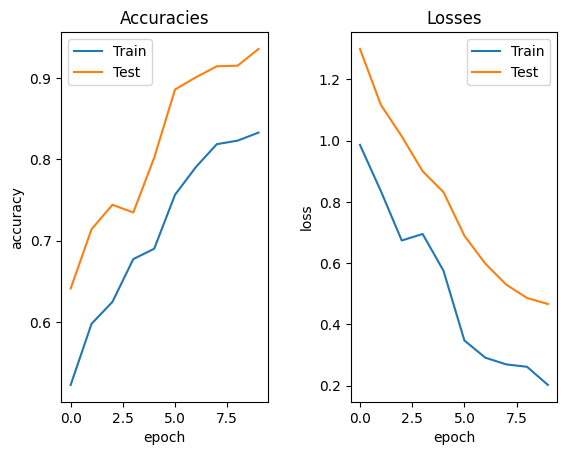

In [ ]:
plt.subplot(1,2,1)
plt.plot(result['train acc'])
plt.plot(result['test acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title('Accuracies')
plt.legend(['Train', 'Test'])

plt.subplot(1,2,2)
plt.plot(result['test loss'])
plt.plot(result['train loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Losses')
plt.legend(['Train', 'Test'])

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

Note that the test accuracy is higher because during training the model is evaluated under harsher conditions (see preprocessing). Plot the confusion matrix:

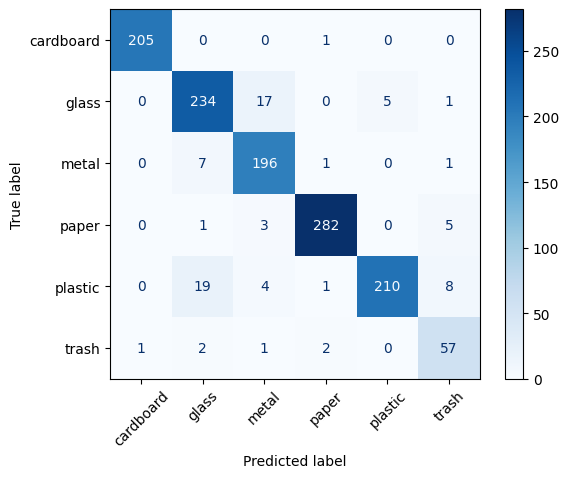

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = torch.cat([p.cpu() for p in result["validation"]["predictions"]]).numpy()
labels = torch.cat([l.cpu() for l in result["validation"]["labels"]]).numpy()

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

We can see that the biggest struggles for this model are glass/plastic. In real life testing paper/cardboard also proved difficult. Sanity check: Plit some predictions.

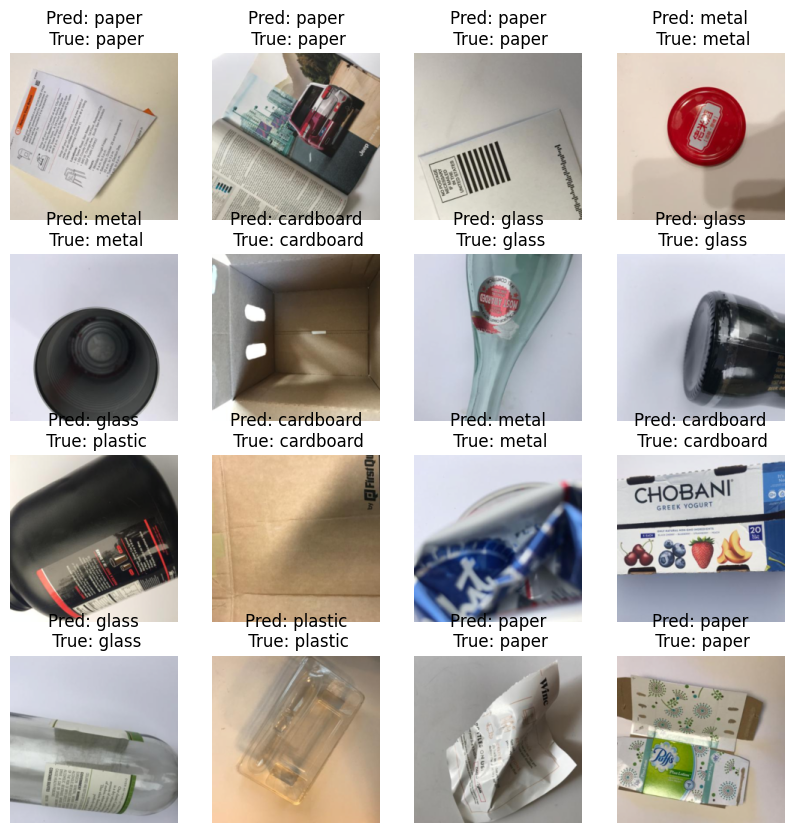

In [ ]:
def visualize_model(model, data):
  with torch.no_grad():
    model.to('cpu')
    fig = plt.figure(figsize=(10,10))
    rows, cols = (4,4)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(1, rows*cols + 1):
      random_idx = torch.randint(1, len(data), size=[1]).item()
      img, label = data[random_idx]
      pred = model(img.unsqueeze(0))
      pred = (torch.max(pred, 1)[1]).item()
      pred_label = next((k for k,v in labels_dic.items() if v == pred))
      img = img.permute(1,2,0).numpy()
      img = img * std + mean
      img = np.clip(img, 0 ,1)
      fig.add_subplot(rows, cols, i)
      plt.imshow(img)
      plt.title(f"Pred: {pred_label}\n True: {label}")
      plt.axis('off')

visualize_model(model, images_test)

In [ ]:
torch.save(model, '/content/models/Trash_classification_v5(full_hyperparams)(94%).pt')